In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog
import seaborn as sns

# Read, format and save raw data from ROIs #

In [35]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
path = Path(askdirectory)
path

WindowsPath('D:/Sofia/2020-03-11_DCX_WT_P191R')

In [36]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(\mu M)$'
DCX = 'DCX'

investigator = 'Sofia'

In [37]:
dateloc = str(path).find("2020")
date = str(path)[dateloc : dateloc+10]

folders = [x for x in path.iterdir() if x.is_dir()]
folders = [i for i in folders if (str(i)[-7:] == 'results') == True]

ch = []
conc_tub = []
conc_DCX = []
DCX_type = []

for i in folders:
    CHloc = str(i).find("CH")
    tubloc = str(i).rfind(tub)
    DCXloc = str(i).rfind(DCX)
    dcxtype = str(i).find("type")
    ch = ch + [str(i)[CHloc+2:CHloc+4]]
    conc_tub = conc_tub + [(str(i)[tubloc+3:tubloc+5])]
    conc_DCX = conc_DCX + [(str(i)[DCXloc+3:DCXloc+6])]
    DCX_type = DCX_type + [(str(i)[dcxtype+4:DCXloc-1])]

date,ch, conc_tub, conc_DCX, DCX_type

('2020-03-11',
 ['12', '13', '21'],
 ['05', '05', '05'],
 ['100', '100', '000'],
 ['WT', 'P191R', 'None'])

In [38]:
tub_conc =  [float(i) for i in conc_tub]
DCX_conc =  [float(i) for i in conc_DCX]
frame_analyzer = pd.read_csv(path/'frame_rates_avg.csv',sep=',')
pixel = 0.0633
folders

[WindowsPath('D:/Sofia/2020-03-11_DCX_WT_P191R/CH12_tub05uM_typeWT_DCX100nM-results'),
 WindowsPath('D:/Sofia/2020-03-11_DCX_WT_P191R/CH13_tub05uM_typeP191R_DCX100nM-results'),
 WindowsPath('D:/Sofia/2020-03-11_DCX_WT_P191R/CH21_tub05uM_typeNone_DCX000nM-results')]

In [39]:
#frame_analyzer = frame_analyzer.iloc[[1,3]].reset_index()
frame_analyzer

,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,D:\Sofia\2020-03-11_DCX_WT_P191R\CH12_tub05uM_...,5.78,0.06,500,3,6.20,9.11
1,D:\Sofia\2020-03-11_DCX_WT_P191R\CH13_tub05uM_...,5.82,0.09,500,1,6.55,16.32
2,D:\Sofia\2020-03-11_DCX_WT_P191R\CH21_tub05uM_...,5.82,0.08,500,2,5.94,2.65


In [40]:
def open_roi_poly(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','x3','y1','y2','y3'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x'][0],'x2': roi_data[key]['x'][1],'x3': roi_data[key]['x'][2],'y1': roi_data[key]['y'][0],'y2': roi_data[key]['y'][1],'y3': roi_data[key]['y'][2]}, ignore_index=True)
    return roi_df

def open_roi_line(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','y1','y2'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x1'],'x2': roi_data[key]['x2'],'y1': roi_data[key]['y1'],'y2': roi_data[key]['y2']}, ignore_index=True)
    return roi_df

In [41]:
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'
poly_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate)
line_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate)

In [42]:
def poly_dynamics(k):
        
    data = open_roi_poly(k,'kymoslopes.zip')
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df = {'Date': np.full((n), date), 'Investigator': np.full((n), investigator),'CH': np.full((n), ch[k]),tubulin: np.full((n), tub_conc[k]),DCXconc: np.full((n), DCX_conc[k])}
    df = pd.DataFrame(pre_df) 
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames-2 else np.NaN, axis=1)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x[Lifetime] != 0 else np.NaN, axis=1)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NAN )
    
    df[TimeToNucleate] = (data['y1']-start)*spf/60
    
    df[ShrinkageLength] = abs((data['x3']-data['x2'])*pixel)
    df[ShrinkageLifetime] = abs((data['y3']-data['y2'])*spf/60)
    df[ShrinkageLifetime] = df[ShrinkageLifetime].apply(lambda x: np.NAN if x == 0 else x)
    df[ShrinkageRate] = df[ShrinkageLength]/df[ShrinkageLifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,Lifetime,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate]] = np.NaN
    
    df['Rescues'] = df[[Length,ShrinkageLength]].apply(lambda x: True if abs(x[Length]-x[ShrinkageLength]) > pixel*5 else False, axis=1)
    
    df['DCX Type'] = DCX_type[k]
        
    return df

def line_dynamics(k):
        
    data = open_roi_line(k,'kymoslopes.zip')
    #data_even = data.iloc[::2].reset_index()
    #data_odd = data.iloc[1::2].reset_index()
    data_even = data
    data_odd = data
    
    supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data_even)
    pre_df = {'Date': np.full((n), date),'CH': np.full((n), ch[k]),'Concentration ' r'$(\mu M)$': np.full((n), conc[k])}
    df = pd.DataFrame(pre_df) 
    
    data_even[Length] = abs((data_even['x2']-data_even['x1'])*pixel)
    data_even[Lifetime] = abs((data_even['y2']-data_even['y1'])*spf/60)
    df[GrowthRate] = data_even[Length]/data_even[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NaN )
    
    data[Lifetime] = abs((data_odd['y2']-data_odd['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    
    df[Length] = df[GrowthRate]*df[Lifetime]
    
    df[TimeToNucleate] = ((data_odd[['y1','y2']].min(axis=1))-start)*spf/60
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,Lifetime,TimeToNucleate]] = np.NaN
    
    df = df[['Date','CH','Concentration ' r'$(\mu M)$',Length,Lifetime,GrowthRate,TimeToNucleate]]
        
    return df

In [43]:
path.parents[0]

WindowsPath('D:/Sofia')

In [44]:
newdirectory = str(path.parents[0])+'//Data_Sheets_methylcellulose'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)

In [45]:
df = poly_dynamics(0)
for i in range(1,len(ch)):
    df0 = poly_dynamics(i)
    df = df.append(df0, ignore_index=True)

df.to_csv(path/(investigator+'_'+date +'.csv'), encoding='utf-8', index=False)
df.to_csv(newmydir/(investigator+'_'+date+'.csv'), encoding='utf-8', index=False)
df

,Date,Investigator,CH,[Tubulin] $(\mu M)$,[DCX] $(\mu M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues,DCX Type
0,2020-03-11,Sofia,12,5.0,100.0,8.4189,10.789333,0.780298,0.385333,3.1017,2.601000,1.1925,True,WT
1,2020-03-11,Sofia,12,5.0,100.0,12.4701,19.652000,0.634546,0.867,2.0256,1.541333,1.31419,True,WT
2,2020-03-11,Sofia,12,5.0,100.0,12.027,19.652000,0.611999,0.192667,6.0768,2.697333,2.25289,True,WT
3,2020-03-11,Sofia,12,5.0,100.0,5.5704,9.922333,0.561400,0.0963333,2.7852,0.770667,3.61401,True,WT
4,2020-03-11,Sofia,12,5.0,100.0,6.0768,12.716000,0.477886,1.156,4.3677,2.408333,1.81358,True,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2020-03-11,Sofia,21,5.0,0.0,3.9246,7.178000,0.546754,5.82,4.0512,0.194000,20.8825,False,None
186,2020-03-11,Sofia,21,5.0,0.0,3.9879,5.917000,0.673973,0.97,3.7347,0.291000,12.834,False,None
187,2020-03-11,Sofia,21,5.0,0.0,5.5704,9.797000,0.568582,1.843,5.697,0.194000,29.366,False,None
188,2020-03-11,Sofia,21,5.0,0.0,10.6977,19.885000,0.537978,3.977,10.6977,0.582000,18.3809,False,None


In [46]:
dfmean = df.groupby('CH').mean()
#dfmean.to_csv(path/(date+'_0_mean.csv'), encoding='utf-8', index=False)
dfmean

,[Tubulin] $(\mu M)$,[DCX] $(\mu M)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Shrink Lifetime $(min)$,Rescues
CH,,,,,,
12,5.0,100.0,10.543148,0.594657,1.873148,0.964286
13,5.0,100.0,9.198639,0.576322,1.140627,0.975904
21,5.0,0.0,6.176506,0.551201,0.241730,0.063291


In [25]:
dfstd = df.groupby('CH').std()
#dfstd.to_csv(path/(date+'_0_std.csv'), encoding='utf-8', index=False)
dfstd

,[Tubulin] $(\mu M)$,[DCX] $(\mu M)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Shrink Lifetime $(min)$,Rescues
CH,,,,,,
12,0.0,0.0,4.957129,0.094106,0.194430,0.189556
13,0.0,0.0,4.904159,0.071797,0.124142,0.000000
23,0.0,0.0,5.943609,0.085030,1.703055,0.174078


# Preliminary plot Histograms #

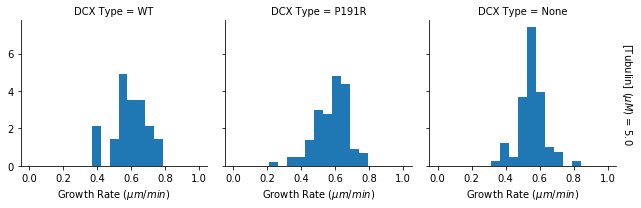

In [56]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 1, 20)
g.map(plt.hist, GrowthRate, bins=bins, density=True)

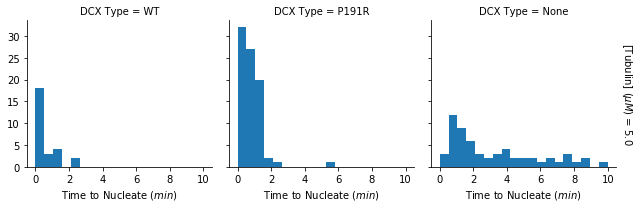

In [49]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 10, 20)
g.map(plt.hist, TimeToNucleate, bins=bins)

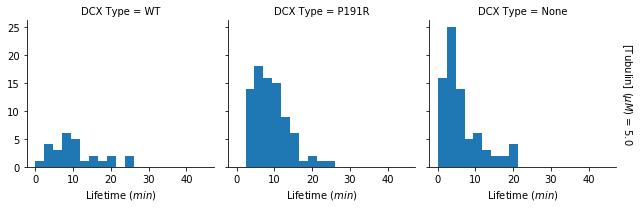

In [50]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 45, 20)
g.map(plt.hist, Lifetime, bins=bins)

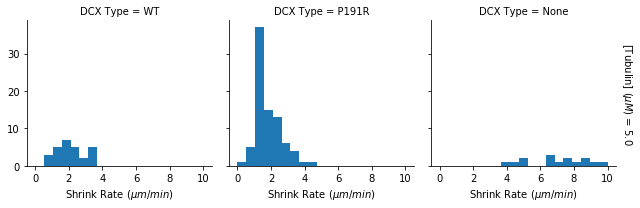

In [53]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 10, 20)
g.map(plt.hist, ShrinkageRate, bins=bins)